In [11]:
import torch
from torch import nn
from d2l import torch as d2l

LeNet-5：由两部分组成，卷积编码器和全连接层密集块。

In [12]:
class Reshape(torch.nn.Module):
    '''将输入x变为批量数不变，通道数为1，形状为28*28'''
    #-1就是根据输入和其他参数自动补齐这个维度，不需要你去计算了
    def forward(self, x):
        return x.view(-1,1,28,28)

In [13]:

net = nn.Sequential(
    Reshape(),
    #将图片放入第一个卷积层，输入通道=1，输出通道=6，卷积核形状为5*5，填充量为2*2，加入sigmoid激活函数使其非线性化
    #第一次卷积输出=（28-5+4+1）/1=28
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    #平均池化层，池化块为2*2，步幅为2，第一层池化层输出=（28-2+2）/2=14
    nn.AvgPool2d(kernel_size=2, stride=2),
    #卷积层，输入通道6，输出通道16，卷积核形状5*5，sigmoid激活函数，第二层卷积层输出=（14-5+1）/1=10
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    #平均池化层2*2，步幅为2，第二层卷积层输出=（10-2+2）/2=5
    nn.AvgPool2d(kernel_size=2, stride=2),
    #将卷积层的4维输出化为一维向量放入多层层感知机，Flatten是保留第一维批量维度的情况下，其他维度全部展平，展平层输出=16(通道数)*5*5（输出张量形状）,
    nn.Flatten(),
    #第六层隐藏层，将输入16*5*5=400缩小为120，加入sigmoid激活函数非线性化
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    #第七层隐藏层，将输入120缩小为84，加入sigmoid激活函数非线性化
    nn.Linear(120, 84), nn.Sigmoid(),
    #输出层，输出10个类别
    nn.Linear(84, 10))

In [14]:
#模型检查，检查每一次的输出维度（批量大小，通道数，矩阵形状）
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


运用fation-MNIST数据集在刚创建的LeNet-5模型上进行测试

In [15]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [16]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [17]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        '''调用xavier_uniform函数初始化全连接层或卷积层'''
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)  #将参数搬运到gpu内存上
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)    #采用SGD定义优化算法
    loss = nn.CrossEntropyLoss()    #交叉熵损失函数
    #绘图动画展示
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            #将输入输出移动到GPU上
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.477, train acc 0.819, test acc 0.792
41462.7 examples/sec on cuda:0


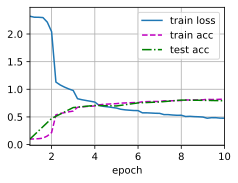

: 

In [18]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())